# **8.The Baseline Modelling**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import email
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
import joblib
df = joblib.load('/content/drive/MyDrive/case study 2/final_40k.pkl')

In [36]:
df.shape

(41474, 2)

In [38]:
df.head()

,mail,len
0,here our forecast,17
1,traveling have business meeting takes the fun ...,534
2,test successful way,19
3,randy can you send schedule the salary and lev...,132
4,let shoot for tuesday,21


In [39]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(df.mail, test_size=0.30, random_state=42)

In [40]:
x = []
y = []
for i in tqdm(train):
  a = i.split()
  for j in range(1,len(a)):
        x.append(' '.join(a[:j]))
        y.append(' '.join(a[j:]))

100%|██████████| 29031/29031 [00:01<00:00, 22693.37it/s]


In [41]:
train_set = pd.DataFrame(data={'x_train':x,'y_train':y})
train_set['x_train'] = '<start> ' + train_set['x_train'] + ' <end>'
train_set['y_train'] = '<start> ' + train_set['y_train'] + ' <end>'
train_set.head()

,x_train,y_train
0,<start> can <end>,<start> everyone meet today please let know da...
1,<start> can everyone <end>,<start> meet today please let know daren <end>
2,<start> can everyone meet <end>,<start> today please let know daren <end>
3,<start> can everyone meet today <end>,<start> please let know daren <end>
4,<start> can everyone meet today please <end>,<start> let know daren <end>


In [48]:
train_set['x_train_len'] = train_set['x_train'].apply(lambda text:len(text.split()))

#here we remove all the rows from x_train / x_test where len is less then 10 and more then 20
train_set = train_set[train_set['x_train_len']>10]
train_set = train_set[train_set['x_train_len']<20]

In [42]:
x_test = []
y_test = []
for i in tqdm(test):
  a = i.split()
  for j in range(1,len(a)):
        x_test.append(' '.join(a[:j]))
        y_test.append(' '.join(a[j:]))

100%|██████████| 12443/12443 [00:00<00:00, 18345.84it/s]


In [43]:
test_set = pd.DataFrame(data={'x_test':x_test,'y_test':y_test})
test_set['x_test'] = '<start> ' + test_set['x_test'] + ' <end>'
test_set['y_test'] = '<start> ' + test_set['y_test'] + ' <end>'
test_set.head()

,x_test,y_test
0,<start> derek <end>,<start> can you forward the <end>
1,<start> derek can <end>,<start> you forward the <end>
2,<start> derek can you <end>,<start> forward the <end>
3,<start> derek can you forward <end>,<start> the <end>
4,<start> begin <end>,<start> get the actual presentations set anyon...


In [71]:
test_set['x_test_len'] = test_set['x_test'].apply(lambda text:len(text.split()))

#here we remove all the rows from x_train / x_test where len is less then 10 and more then 20
test_set = test_set[test_set['x_test_len']>10]
test_set = test_set[test_set['x_test_len']<20]
test_set.shape

(64032, 3)

In [72]:
tk = Tokenizer()#filters: If not provided, by default filters out all punctuation terms
tk_text = tk.fit_on_texts(list(train_set.x_train))
vocab = len(tk.word_index) + 1
print('the vocab size is', vocab)

the vocab size is 8785


In [73]:
#now we convert train and text datainto a corresponding index
train_seq = tk.texts_to_sequences(list(train_set.x_train))
print('the length of the train seq' ,len(train_seq[0]))
#took padding length as 9000 because in each data points has avg 30 words sentence.
train_data = pad_sequences(train_seq ,padding="post", maxlen=30)

test_seq = tk.texts_to_sequences(list(test_set.x_test))
print('the length of test seq',len(test_seq[0]))
test_data = pad_sequences(test_seq, padding="post",maxlen=30)

the length of the train seq 11
the length of test seq 11


In [74]:
tk_y = Tokenizer()#filters: If not provided, by default filters out all punctuation terms
tk_text_y = tk_y.fit_on_texts(list(train_set.y_train))
vocab_y = len(tk_y.word_index) + 1
print('the vocab size is', vocab_y)

the vocab size is 9549


In [75]:
#now we convert train and text datainto a corresponding index
train_seq_y = tk_y.texts_to_sequences(list(train_set.y_train))
print('the length of the train seq' ,len(train_seq_y[0]))
#took padding length as 9000 because in each data points has avg 30 words sentence.
train_data_y = pad_sequences(train_seq_y ,padding="post", maxlen=30)

test_seq_y = tk_y.texts_to_sequences(list(test_set.y_test))
print('the length of test seq',len(test_seq_y[0]))
test_data_y = pad_sequences(test_seq_y, padding="post",maxlen=30)

the length of the train seq 3
the length of test seq 38


In [77]:
#the very very basic LSTM model with the some hidden layes
tf.keras.backend.clear_session()
input_lay = tf.keras.Input(shape=(30,))

emd_layer = tf.keras.layers.Embedding(vocab, 300, input_length=30)(input_lay)
dense1 = tf.keras.layers.LSTM(300,return_sequences=True)(emd_layer)

dropout_lay1 = tf.keras.layers.Dropout(rate = 0.3 , name = 'dropout_lay1')(dense1)

dense2 = tf.keras.layers.Dense(512,activation='relu', kernel_initializer=tf.keras.initializers.he_normal, name = 'dense2')(dropout_lay1)

dropout_lay2 = tf.keras.layers.Dropout(rate = 0.3 , name = 'dropout_lay2')(dense2)

dense3 = tf.keras.layers.Dense(512,activation='relu', kernel_initializer=tf.keras.initializers.he_normal ,name = 'dense3')(dropout_lay2)

output = tf.keras.layers.Dense(vocab_y,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal , name = 'output')(dense3)

model = tf.keras.Model(inputs= input_lay, outputs=output)

In [78]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           2635500   
                                                                 
 lstm (LSTM)                 (None, 30, 300)           721200    
                                                                 
 dropout_lay1 (Dropout)      (None, 30, 300)           0         
                                                                 
 dense2 (Dense)              (None, 30, 512)           154112    
                                                                 
 dropout_lay2 (Dropout)      (None, 30, 512)           0         
                                                                 
 dense3 (Dense)              (None, 30, 512)           262656

In [79]:
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [80]:
his = model.fit(train_data, train_data_y, epochs=10, validation_data=(test_data,test_data_y) , batch_size=512)

Epoch 1/10
295/295 [==============================] - 78s 257ms/step - loss: 4.4287 - accuracy: 0.4287 - val_loss: 4.2585 - val_accuracy: 0.4386
Epoch 2/10
295/295 [==============================] - 75s 254ms/step - loss: 4.0479 - accuracy: 0.4372 - val_loss: 4.3853 - val_accuracy: 0.4335
Epoch 3/10
295/295 [==============================] - 75s 253ms/step - loss: 3.8762 - accuracy: 0.4414 - val_loss: 4.5974 - val_accuracy: 0.4108
Epoch 4/10
295/295 [==============================] - 75s 254ms/step - loss: 3.7059 - accuracy: 0.4478 - val_loss: 4.9647 - val_accuracy: 0.4038
Epoch 5/10
295/295 [==============================] - 75s 254ms/step - loss: 3.5424 - accuracy: 0.4542 - val_loss: 5.3767 - val_accuracy: 0.3863
Epoch 6/10
295/295 [==============================] - 75s 254ms/step - loss: 3.3925 - accuracy: 0.4603 - val_loss: 5.5857 - val_accuracy: 0.3733
Epoch 7/10
295/295 [==============================] - 75s 253ms/step - loss: 3.2563 - accuracy: 0.4658 - val_loss: 5.7213 - val_ac

In [81]:
h = his.history
loss = h['loss']
val_loss = h['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

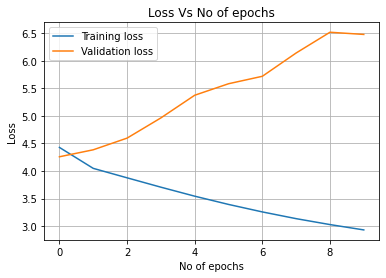

In [82]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

Text(0.5, 1.0, 'accuracy Vs No of epochs')

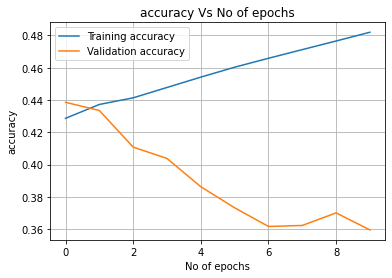

In [83]:
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']
plt.plot(accuracy,label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('accuracy')
plt.title('accuracy Vs No of epochs')

In [101]:
eng_word = tk_y.word_index
new_dict = dict([(value, key) for key, value in eng_word.items()])

In [102]:
import numpy as np
def predict(train):
  a = model.predict(train.reshape(-1,30))
  f = []
  d = []
  for i in a[0]:
    #print(i)
    f.append(np.argmax(i))
  for  i in f:
    if i != 0:
      d.append(new_dict[i])

  return(' '.join(d))

In [103]:
predict(train_data[185])

'start responded normally the the the enron attorney attorney mexico internal internal internal internal signed appointed appointed appointed tax into into this this this add your your thanks regards end'

In [104]:
data_sam = train_set.sample(15000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in tqdm(range(15000)):
  actual  = data_sam.y_train.values[i]
  input = tk.texts_to_sequences([str(data_sam.x_train.values[i])])
  input = pad_sequences(input, padding="post",maxlen= 30)
  Predict = predict(input)
  bleu_score.append(bleu.sentence_bleu([actual.split(),], Predict.split()))
print()
print('Bleu Score ==> ', np.mean(bleu_score))

  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/15000 [00:00<10:58, 22.79it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 9/15000 [00:00<11:28, 21.77it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 15000/15000 [11:30<00:00, 21.73it/s]


Bleu Score ==>  0.2063198597853522


**The Bleu score is 0.20 and improves the bleu score we use the encoder and decoder-based model.**